In [1]:
# Import the libraries we'll use below.
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns  # for nicer plots
sns.set(style="darkgrid")  # default style

import tensorflow as tf
from tensorflow import keras
from keras import metrics
from sklearn.model_selection import train_test_split
tf.get_logger().setLevel('INFO')

import os
from os import listdir
from PIL import Image

from imblearn.over_sampling import SMOTE
import cv2
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img

2023-11-17 12:24:02.603267: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
## Might need to install SMOTE. After install, I needed to close anaconda/jupyter notebook and reopen it for it to
## work :) - Kara
##Also import opencv-python for image augmentation- Negin
# import sys
# !{sys.executable} -m pip install imbalanced-learn

### Load Data

In [3]:
df = pd.read_csv('KidneyImages/kidneyData.csv')

In [4]:
display(df)

,Unnamed: 0,image_id,path,diag,target,Class
0,0,Tumor- (1044),"/content/data/CT KIDNEY DATASET Normal, CYST, ...",Tumor,3,Tumor
1,1,Tumor- (83),"/content/data/CT KIDNEY DATASET Normal, CYST, ...",Tumor,3,Tumor
2,2,Tumor- (580),"/content/data/CT KIDNEY DATASET Normal, CYST, ...",Tumor,3,Tumor
3,3,Tumor- (1701),"/content/data/CT KIDNEY DATASET Normal, CYST, ...",Tumor,3,Tumor
4,4,Tumor- (1220),"/content/data/CT KIDNEY DATASET Normal, CYST, ...",Tumor,3,Tumor
...,...,...,...,...,...,...
12441,12441,Cyst- (2522),"/content/data/CT KIDNEY DATASET Normal, CYST, ...",Cyst,0,Cyst
12442,12442,Cyst- (2627),"/content/data/CT KIDNEY DATASET Normal, CYST, ...",Cyst,0,Cyst
12443,12443,Cyst- (972),"/content/data/CT KIDNEY DATASET Normal, CYST, ...",Cyst,0,Cyst
12444,12444,Cyst- (2323),"/content/data/CT KIDNEY DATASET Normal, CYST, ...",Cyst,0,Cyst


In [5]:
newsize = (256, 256)

In [6]:
## Read in all images
# First, read in all cyst images

cystImages = []

# Get the correct folder of images
folder_dir = "KidneyImages/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Cyst"


for images in os.listdir(folder_dir): # For each item in the folder
    if (images.endswith(".jpg")): # If it is a jpg
        image = Image.open(folder_dir + '/' + images) # Open the image
        image = image.resize(newsize) # Resize it to 256x256
        npImage = np.asarray(image) # Turn it into an array
        reshapedImage = npImage[:, :, 0] # Get rid of the last two color values (since it is black and white)
        cystImages.append({'image_id': images[:-4], 'image': reshapedImage}) # Add the information to the dictionary

In [7]:
# Then all normal images
normalImages = []

folder_dir = "KidneyImages/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Normal"


for images in os.listdir(folder_dir):
    if (images.endswith(".jpg")):
        image = Image.open(folder_dir + '/' + images)
        image = image.resize(newsize)
        npImage = np.asarray(image)
        reshapedImage = npImage[:, :, 0]

        normalImages.append({'image_id': images[:-4], 'image': reshapedImage})

In [8]:
# Then all stone images
stoneImages = []

folder_dir = "KidneyImages/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Stone"


for images in os.listdir(folder_dir):
    if (images.endswith(".jpg")):
        image = Image.open(folder_dir + '/' + images)
        image = image.resize(newsize)
        npImage = np.asarray(image)
        reshapedImage = npImage[:, :, 0]

        stoneImages.append({'image_id': images[:-4], 'image': reshapedImage})

In [9]:
# Then all tumor images
tumorImages = []

folder_dir = "KidneyImages/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Tumor"


for images in os.listdir(folder_dir):
    if (images.endswith(".jpg")):
        image = Image.open(folder_dir + '/' + images)
        image = image.resize(newsize)
        npImage = np.asarray(image)
        reshapedImage = npImage[:, :, 0]

        tumorImages.append({'image_id': images[:-4], 'image': reshapedImage})

In [10]:
# Concatenate all list of images, and turn into a data frame

allImages = cystImages + stoneImages + normalImages + tumorImages

imgs = pd.DataFrame(allImages)

In [11]:
imgs

,image_id,image
0,Cyst- (630),"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1,Cyst- (260),"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
2,Cyst- (1631),"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
3,Cyst- (1261),"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
4,Cyst- (1774),"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
...,...,...
12441,Tumor- (209),"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
12442,Tumor- (1390),"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
12443,Tumor- (659),"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
12444,Tumor- (1685),"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


In [12]:
# Make a dictionary of labels
labelDictionary = {0: 'Cyst', 1: 'Normal', 2: 'Stone', 3:'Tumor'}

In [13]:
# Merge with the other dataframe to get each image matched with its label
imgWithLabel = imgs.merge(df, how = 'inner', on = 'image_id')
imgWithLabel = imgWithLabel[['image', 'target']]

In [76]:
X = imgWithLabel['image'].to_numpy()
y = imgWithLabel['target'].to_numpy()
print(X.shape)


(12446,)


### Perform SMOTE

In [77]:
# Reshape/ unpack the array of images, then flatten it so it is prepared for smote
X = np.array([x for x in X])
print(X.shape)
nsamples, nx, ny = X.shape
X = X.reshape((nsamples,nx*ny))
print(X.shape)

(12446, 256, 256)
(12446, 65536)


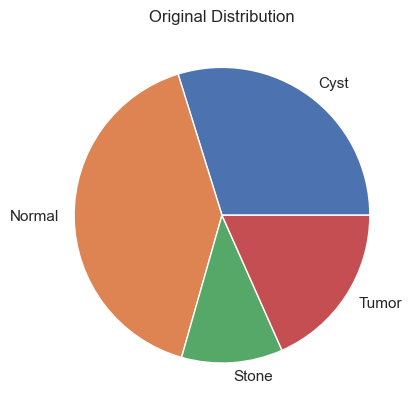

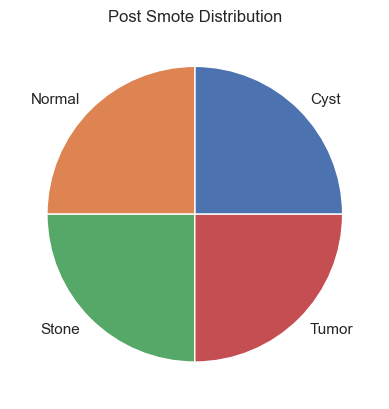

In [78]:
# SMOTE to balance classes

# Original class distribution
unique, counts = np.unique(y, return_counts=True)
uniqueLables = [labelDictionary[x] for x in unique]
plt.pie(counts, labels = uniqueLables)
plt.title('Original Distribution')
plt.show()

# Perform SMOTE sampling
oversample = SMOTE()
Xsmote, ysmote = oversample.fit_resample(X, y)


# Updated class distribution
uniquesmote, countssmote = np.unique(ysmote, return_counts=True)
uniqueLablessmote = [labelDictionary[x] for x in uniquesmote]
plt.pie(countssmote, labels = uniqueLablessmote)
plt.title('Post Smote Distribution')
plt.show()

### Shuffle & reshape the data

In [79]:
np.random.seed(42)
indices = np.arange(Xsmote.shape[0])
shuffled_indices = np.random.permutation(indices)
Xshuffled = Xsmote[shuffled_indices]
yshuffled = ysmote[shuffled_indices]

In [80]:
# Reshape the data to 4 dimensional data for model training
Xshuffled = Xshuffled.reshape((20308,256,256,-1))

In [81]:
# c = plt.imshow(Xshuffled[1,:,:,:],cmap='gray')
# plt.show()

### Train and test split

In [82]:
X_train, X_test, y_train, y_test = train_test_split(Xshuffled, yshuffled, test_size=0.2, random_state=1)

In [83]:
# Create an intermediary validation set 
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

### Image Augmentation

In [22]:
# Create augmentation layers
data_augmentation = keras.Sequential(
    [
        keras.layers.RandomFlip("horizontal"),
        keras.layers.RandomRotation(0.1),
    ],
)

2023-11-17 12:23:19.076194: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [23]:
example_image = X_train[2]
print(example_image.shape)


(256, 256, 1)


In [26]:
# def rotate_image(image):
#     # Random angle between -20 and 20 degrees
#     angle = np.random.uniform(-20, 20)
#     rotated_image = np.interp(np.arange(len(image)), np.arange(len(image)) + angle, image, left=0, right=0)
#     return rotated_image

# def zoom_image(image):
#     # Random zoom factor between 0.8 and 1.2
#     zoom_factor = np.random.uniform(0.8, 1.2)
#     zoomed_image = np.interp(np.arange(len(image)), np.arange(len(image)) * zoom_factor, image, left=0, right=0)
#     return zoomed_image

# def flip_image(image):
#     # Randomly flip the image horizontally
#     if np.random.rand() > 0.5:
#         flipped_image = np.flip(image)
#     else:
#         flipped_image = image
#     return flipped_image

# def augment_image(image):
#     # Apply rotation
#     rotated_image = rotate_image(image)
    
#     # Apply zoom
#     zoomed_image = zoom_image(rotated_image)
    
#     # Apply flip
#     flipped_image = flip_image(zoomed_image)

#     return flipped_image

# # Perform image augmentation on the training data
# X_train_augmented = [augment_image(image) for image in X_train]

# # Convert the augmented data back to NumPy array
# X_train_augmented = np.array(X_train_augmented)

# # Concatenate the original and augmented data
# X_train_combined = np.concatenate((X_train, X_train_augmented))
# y_train_combined = np.concatenate((y_train, y_train.copy()))  

# # Ensure X_train_combined and y_train_combined have the correct shapes
# print(X_train_combined.shape)
# print(y_train_combined.shape)



In [27]:
# X_train = X_train_combined 
# y_train = y_train_combined

In [28]:
# X_train = np.stack(X_train, axis=0)
# Y_train = np.stack(y_train, axis=0)
# X_test = np.stack(X_test, axis=0)
# Y_test = np.stack(y_test, axis=0)

### Create Models

In [24]:
def build_multiclass_model(n_classes, learning_rate=0.01):
    """
    Build a multi-class logistic regression model using Keras.

    Args:
    n_classes: Number of classes in the dataset
    learning_rate: The desired learning rate for SGD.

    Returns:
    model: A tf.keras model (graph).
    """
   
    model = keras.Sequential([
        data_augmentation,
        keras.layers.Flatten(),
        keras.layers.Dense(units=n_classes, activation="softmax")
    ])

    optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)

    model.compile(loss='sparse_categorical_crossentropy',
                optimizer=optimizer,
                metrics=['accuracy'])
    return model

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(0)

model = build_multiclass_model(4, 0.01)

history = model.fit(
  x = X_train,
  y = y_train,
  epochs=5,
  batch_size=128,
  validation_split=0.1,
  verbose=1)

history = pd.DataFrame(history.history)
display(history)

In [ ]:
test_predictions = np.argmax(model.predict(X_val), axis=-1)
print(test_predictions)

In [ ]:
# Create a confusion matrix as a 2D array.
confusion_matrix = tf.math.confusion_matrix(y_val, test_predictions)

# Use a heatmap plot to display it.
ax = sns.heatmap(confusion_matrix, annot=True, fmt='.3g', cmap='Blues',
                 xticklabels=['Cyst','Normal','Stone','Tumor'], yticklabels=['Cyst','Normal','Stone','Tumor'], 
                 cbar=False)

# Add axis labels.
ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.show()

In [22]:
def build_model(n_classes,   #should we change the n_classes to 4? since we only have 4 classes
                hidden_layer_sizes=[],
                activation='relu',
                optimizer='SGD',
                learning_rate=0.01):
    tf.keras.backend.clear_session()
    np.random.seed(0)
    tf.random.set_seed(0)
    model = tf.keras.models.Sequential()
    # Flatten the input shape
    model.add(tf.keras.layers.Flatten())
    # Add hidden layers
    for layer_size in hidden_layer_sizes:
        model.add(tf.keras.layers.Dense(layer_size, activation=activation))
    #Add the last neural network layer
    model.add(tf.keras.layers.Dense(units=n_classes, activation='softmax'))
    if optimizer == 'SGD':
        model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate),
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])
    elif optimizer == 'Adam':
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])
    elif optimizer == 'RMSprop':
        model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=learning_rate),
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])
    else:
        raise ValueError("Invalid optimizer. Please choose from ‘SGD’, ‘Adam’, or ‘RMSprop’.")
    return model


Epoch 1/5
129/129 [==============================] - 4s 27ms/step - loss: 1413756.0000 - accuracy: 0.2534 - val_loss: 1.3834 - val_accuracy: 0.2352
Epoch 2/5
129/129 [==============================] - 3s 25ms/step - loss: 1.7116 - accuracy: 0.2594 - val_loss: 1.3637 - val_accuracy: 0.2495
Epoch 3/5
129/129 [==============================] - 3s 25ms/step - loss: 5.6168 - accuracy: 0.2609 - val_loss: 1.3836 - val_accuracy: 0.2352
Epoch 4/5
129/129 [==============================] - 3s 25ms/step - loss: 1.3818 - accuracy: 0.2554 - val_loss: 1.3836 - val_accuracy: 0.2352
Epoch 5/5
129/129 [==============================] - 3s 25ms/step - loss: 1.3817 - accuracy: 0.2554 - val_loss: 1.3836 - val_accuracy: 0.2352
96/96 - 0s - loss: 1.3839 - accuracy: 0.2400 - 472ms/epoch - 5ms/step


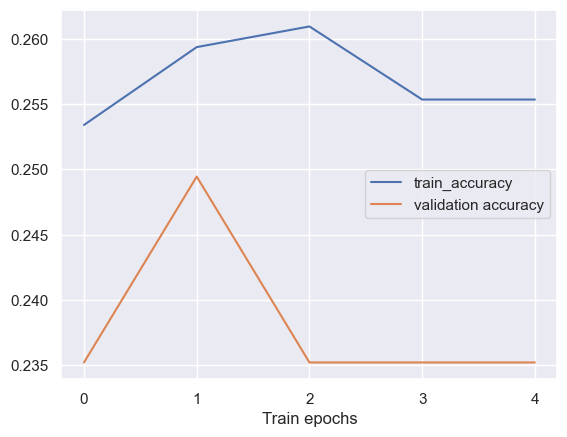

In [32]:
# Change the shape
#### I don't think we need these anymore since I reshaped before smote!
# X_train = np.array([np.asarray(x).flatten() for x in X_train]).astype(np.float32)
# y_train = np.array([np.asarray(y) for y in y_train]).astype(np.float32)
# X_test = np.array([np.asarray(x).flatten() for x in X_train]).astype(np.float32)
# y_test = np.array([np.asarray(y) for y in y_train]).astype(np.float32)



# Build and compile the model
model = build_model(n_classes=4, hidden_layer_sizes=[128], activation='relu', optimizer='SGD', learning_rate=0.01)

# Train the model for 5 epochs
history = model.fit(X_train, y_train, epochs=5, batch_size=64, validation_split=0.1, verbose=1)
test_loss, test_accuracy = model.evaluate(X_val, y_val, verbose=2)




train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
plt.plot(train_accuracy, label='train_accuracy')
plt.plot(val_accuracy, label='validation accuracy')
plt.xticks(range(5))
plt.xlabel('Train epochs')
plt.legend()
plt.show()


Epoch 1/5
129/129 [==============================] - 5s 34ms/step - loss: 6816.1768 - accuracy: 0.5083 - val_loss: 2.9752 - val_accuracy: 0.4825
Epoch 2/5
129/129 [==============================] - 4s 33ms/step - loss: 8.6163 - accuracy: 0.3230 - val_loss: 1.3655 - val_accuracy: 0.2637
Epoch 3/5
129/129 [==============================] - 4s 33ms/step - loss: 8.9712 - accuracy: 0.2611 - val_loss: 1.3652 - val_accuracy: 0.2681
Epoch 4/5
129/129 [==============================] - 4s 34ms/step - loss: 1.3666 - accuracy: 0.2545 - val_loss: 1.3653 - val_accuracy: 0.2681
Epoch 5/5
129/129 [==============================] - 4s 34ms/step - loss: 1.3667 - accuracy: 0.2612 - val_loss: 1.3658 - val_accuracy: 0.2407
96/96 - 0s - loss: 1.3701 - accuracy: 0.2416 - 472ms/epoch - 5ms/step


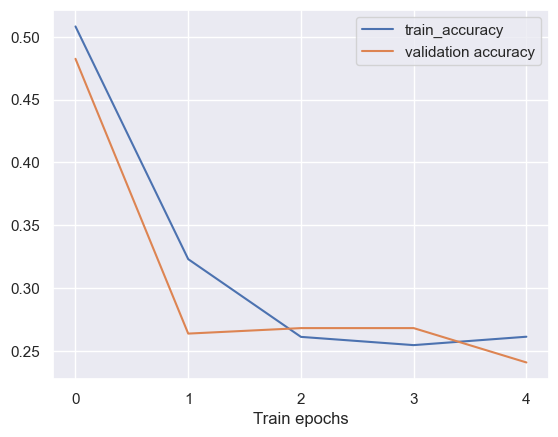

In [33]:
model = build_model(n_classes=4, hidden_layer_sizes=[128], activation='relu', optimizer='RMSprop', learning_rate=0.01)

# Train the model for 5 epochs
history = model.fit(X_train, y_train, epochs=5, batch_size=64, validation_split=0.1, verbose=1)
test_loss, test_accuracy = model.evaluate(X_val, y_val, verbose=2)

train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
plt.plot(train_accuracy, label='train_accuracy')
plt.plot(val_accuracy, label='validation accuracy')
plt.xticks(range(5))
plt.xlabel('Train epochs')
plt.legend()
plt.show()

Epoch 1/5
129/129 [==============================] - 5s 39ms/step - loss: 2240.1912 - accuracy: 0.7885 - val_loss: 190.2775 - val_accuracy: 0.8534
Epoch 2/5
129/129 [==============================] - 5s 38ms/step - loss: 37.0189 - accuracy: 0.9570 - val_loss: 46.5053 - val_accuracy: 0.9398
Epoch 3/5
129/129 [==============================] - 5s 38ms/step - loss: 11.7513 - accuracy: 0.9819 - val_loss: 40.6959 - val_accuracy: 0.9453
Epoch 4/5
129/129 [==============================] - 5s 38ms/step - loss: 18.8334 - accuracy: 0.9756 - val_loss: 5.0632 - val_accuracy: 0.9880
Epoch 5/5
129/129 [==============================] - 5s 38ms/step - loss: 8.6997 - accuracy: 0.9839 - val_loss: 116.9685 - val_accuracy: 0.8687
96/96 - 0s - loss: 140.2892 - accuracy: 0.8749 - 478ms/epoch - 5ms/step


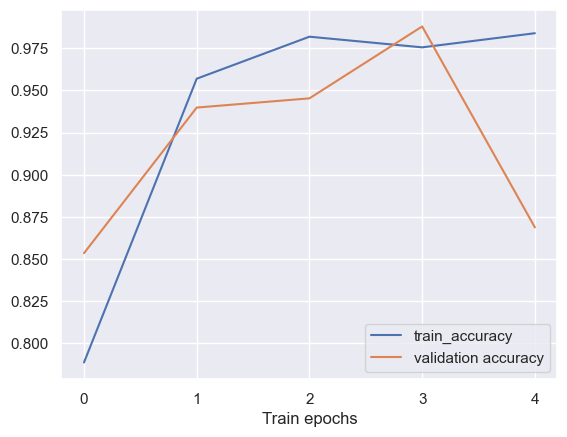

In [34]:
model = build_model(n_classes=4, hidden_layer_sizes=[128], activation='relu', optimizer='Adam', learning_rate=0.01)

# Train the model for 5 epochs
history = model.fit(X_train, y_train, epochs=5, batch_size=64, validation_split=0.1, verbose=1)
test_loss, test_accuracy = model.evaluate(X_val, y_val, verbose=2)


train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
plt.plot(train_accuracy, label='train_accuracy')
plt.plot(val_accuracy, label='validation accuracy')
plt.xticks(range(5))
plt.xlabel('Train epochs')
plt.legend()
plt.show()

In [84]:
import tensorflow as tf
from tensorflow.keras import layers, models

def build_cnn_model(input_shape, n_classes, optimizer='SGD', learning_rate=0.01):
 
    np.random.seed(0)
    tf.random.set_seed(0)

    model = models.Sequential()

    # Convolutional layers
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Flatten())

    # Dense layers
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(n_classes, activation='softmax'))

    if optimizer == 'SGD':
        model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate),
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])
    elif optimizer == 'Adam':
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])
    elif optimizer == 'RMSprop':
        model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=learning_rate),
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])
    else:
        raise ValueError("Invalid optimizer. Please choose from ‘SGD’, ‘Adam’, or ‘RMSprop’.")

    return model


In [85]:
input_shape = (32, 32, 3)  # Change this according to your image dimensions

In [88]:
new_shape = (32, 32, 3)  
X_train_reshaped = np.reshape(X_train, (-1, 256, 256, 1))  
X_val_reshaped = np.reshape(X_val, (-1, 256, 256, 1))  
# Normalize pixel values to range [0, 1]
X_train_reshaped = X_train_reshaped / 255.0
X_val_reshaped = X_val_reshaped / 255.0


X_train_resized = np.array([tf.image.resize(image, (32, 32)) for image in X_train_reshaped])
X_val_resized = np.array([tf.image.resize(image, (32, 32)) for image in X_val_reshaped])


In [89]:
X_train_rgb = np.repeat(X_train_resized[..., np.newaxis], 3, axis=-1)
X_val_rgb = np.repeat(X_val_resized[..., np.newaxis], 3, axis=-1)

# Reshape to remove the extra dimension
X_train_rgb = np.squeeze(X_train_rgb, axis=3)
X_val_rgb = np.squeeze(X_val_rgb, axis=3)


In [99]:
# Train the CNN model for 5 epochs
cnn_model = build_cnn_model(input_shape, n_classes=4, optimizer='SGD', learning_rate=0.01)
history_cnn = cnn_model.fit(X_train_rgb, y_train, epochs=10, batch_size=64, validation_split=0.1, verbose=1)
test_loss_cnn, test_accuracy_cnn = cnn_model.evaluate(X_val_rgb, y_val, verbose=2)

Epoch 1/10
172/172 [==============================] - 3s 19ms/step - loss: 1.3715 - accuracy: 0.2981 - val_loss: 1.3519 - val_accuracy: 0.3790
Epoch 2/10
172/172 [==============================] - 3s 18ms/step - loss: 1.3035 - accuracy: 0.4806 - val_loss: 1.2456 - val_accuracy: 0.5496
Epoch 3/10
172/172 [==============================] - 3s 18ms/step - loss: 1.1439 - accuracy: 0.5544 - val_loss: 1.0841 - val_accuracy: 0.5324
Epoch 4/10
172/172 [==============================] - 3s 19ms/step - loss: 1.0306 - accuracy: 0.5796 - val_loss: 1.0074 - val_accuracy: 0.6153
Epoch 5/10
172/172 [==============================] - 3s 18ms/step - loss: 0.9739 - accuracy: 0.6079 - val_loss: 0.9485 - val_accuracy: 0.6177
Epoch 6/10
172/172 [==============================] - 3s 19ms/step - loss: 0.8979 - accuracy: 0.6436 - val_loss: 0.8541 - val_accuracy: 0.6899
Epoch 7/10
172/172 [==============================] - 3s 19ms/step - loss: 0.8359 - accuracy: 0.6754 - val_loss: 0.8054 - val_accuracy: 0.6866

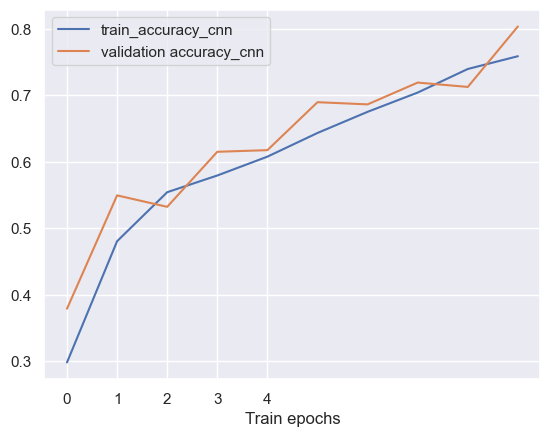

In [100]:
train_accuracy_cnn = history_cnn.history['accuracy']
val_accuracy_cnn = history_cnn.history['val_accuracy']

plt.plot(train_accuracy_cnn, label='train_accuracy_cnn')
plt.plot(val_accuracy_cnn, label='validation accuracy_cnn')
plt.xticks(range(5))
plt.xlabel('Train epochs')
plt.legend()
plt.show()

In [106]:
cnn_model = build_cnn_model(input_shape, n_classes=4, optimizer='Adam', learning_rate=0.01)
history_cnn = cnn_model.fit(X_train_rgb, y_train, epochs=10, batch_size=64, validation_split=0.1, verbose=1)
test_loss_cnn, test_accuracy_cnn = cnn_model.evaluate(X_val_rgb, y_val, verbose=2)

Epoch 1/10
172/172 [==============================] - 4s 19ms/step - loss: 1.1437 - accuracy: 0.4754 - val_loss: 0.7917 - val_accuracy: 0.6719
Epoch 2/10
172/172 [==============================] - 3s 18ms/step - loss: 0.5028 - accuracy: 0.8025 - val_loss: 0.3295 - val_accuracy: 0.8753
Epoch 3/10
172/172 [==============================] - 3s 18ms/step - loss: 0.2300 - accuracy: 0.9185 - val_loss: 0.2183 - val_accuracy: 0.9245
Epoch 4/10
172/172 [==============================] - 3s 18ms/step - loss: 0.1458 - accuracy: 0.9505 - val_loss: 0.1818 - val_accuracy: 0.9385
Epoch 5/10
172/172 [==============================] - 3s 18ms/step - loss: 0.1220 - accuracy: 0.9570 - val_loss: 0.1457 - val_accuracy: 0.9475
Epoch 6/10
172/172 [==============================] - 3s 18ms/step - loss: 0.0808 - accuracy: 0.9724 - val_loss: 0.1649 - val_accuracy: 0.9500
Epoch 7/10
172/172 [==============================] - 3s 18ms/step - loss: 0.0838 - accuracy: 0.9712 - val_loss: 0.1782 - val_accuracy: 0.9516

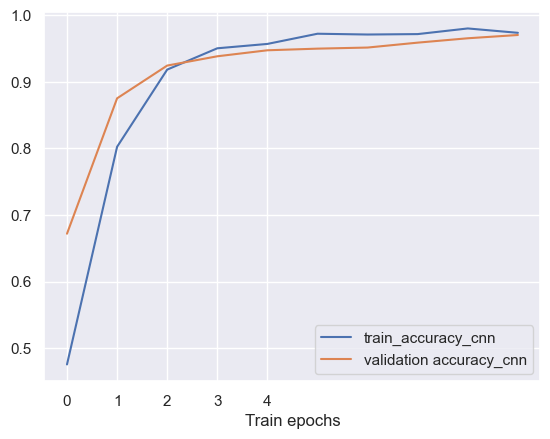

In [107]:
train_accuracy_cnn = history_cnn.history['accuracy']
val_accuracy_cnn = history_cnn.history['val_accuracy']

plt.plot(train_accuracy_cnn, label='train_accuracy_cnn')
plt.plot(val_accuracy_cnn, label='validation accuracy_cnn')
plt.xticks(range(5))
plt.xlabel('Train epochs')
plt.legend()
plt.show()

In [108]:
cnn_model = build_cnn_model(input_shape, n_classes=4, optimizer='RMSprop', learning_rate=0.01)
history_cnn = cnn_model.fit(X_train_rgb, y_train, epochs=10, batch_size=64, validation_split=0.1, verbose=1)
test_loss_cnn, test_accuracy_cnn = cnn_model.evaluate(X_val_rgb, y_val, verbose=2)

Epoch 1/10
172/172 [==============================] - 3s 18ms/step - loss: 1.3871 - accuracy: 0.4117 - val_loss: 1.1459 - val_accuracy: 0.5431
Epoch 2/10
172/172 [==============================] - 3s 18ms/step - loss: 0.5832 - accuracy: 0.7750 - val_loss: 0.6212 - val_accuracy: 0.7908
Epoch 3/10
172/172 [==============================] - 3s 19ms/step - loss: 0.2289 - accuracy: 0.9206 - val_loss: 0.2031 - val_accuracy: 0.9360
Epoch 4/10
172/172 [==============================] - 3s 18ms/step - loss: 0.1383 - accuracy: 0.9582 - val_loss: 0.1446 - val_accuracy: 0.9401
Epoch 5/10
172/172 [==============================] - 3s 18ms/step - loss: 0.1052 - accuracy: 0.9690 - val_loss: 0.0961 - val_accuracy: 0.9705
Epoch 6/10
172/172 [==============================] - 3s 18ms/step - loss: 0.0988 - accuracy: 0.9761 - val_loss: 0.0612 - val_accuracy: 0.9811
Epoch 7/10
172/172 [==============================] - 3s 18ms/step - loss: 0.0827 - accuracy: 0.9779 - val_loss: 0.0997 - val_accuracy: 0.9721

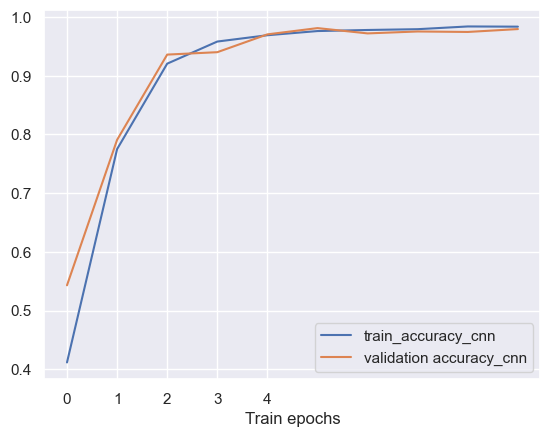

In [109]:
train_accuracy_cnn = history_cnn.history['accuracy']
val_accuracy_cnn = history_cnn.history['val_accuracy']

plt.plot(train_accuracy_cnn, label='train_accuracy_cnn')
plt.plot(val_accuracy_cnn, label='validation accuracy_cnn')
plt.xticks(range(5))
plt.xlabel('Train epochs')
plt.legend()
plt.show()